In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from math import sqrt
import sys, os
from contextlib import contextmanager
import matplotlib as mpl
import seaborn as sns
import sklearn

In [2]:
data = pd.read_csv('forecasting_data.csv')
data.head(12)

,Period,Sales
0,1,5384
1,2,8081
2,3,10282
3,4,9156
4,5,6118
5,6,9139
6,7,12460
7,8,10717
8,9,7825
9,10,9693


In [3]:
data.shape

(12, 2)

# Interpreting pattern of time series

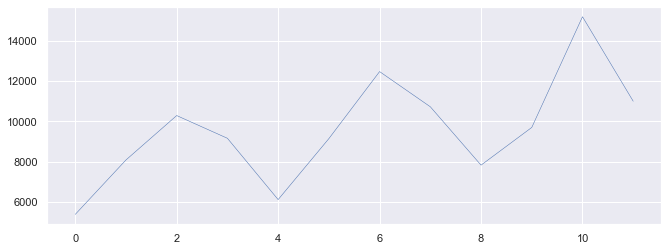

In [4]:
sns.set(rc={'figure.figsize':(11, 4)})
data['Sales'].plot(linewidth=0.5);

# Using seasonality

In [5]:
for i in range(0,data.shape[0]-3):
    data.loc[data.index[i+3],'MA_4'] = np.round(((data.iloc[i,1]+ data.iloc[i+1,1] +data.iloc[i+2,1]+data.iloc[i+3,1])/4),1)

In [6]:
data

,Period,Sales,MA_4
0,1,5384,NaN
1,2,8081,NaN
2,3,10282,NaN
3,4,9156,8225.8
4,5,6118,8409.2
5,6,9139,8673.8
6,7,12460,9218.2
7,8,10717,9608.5
8,9,7825,10035.2
9,10,9693,10173.8


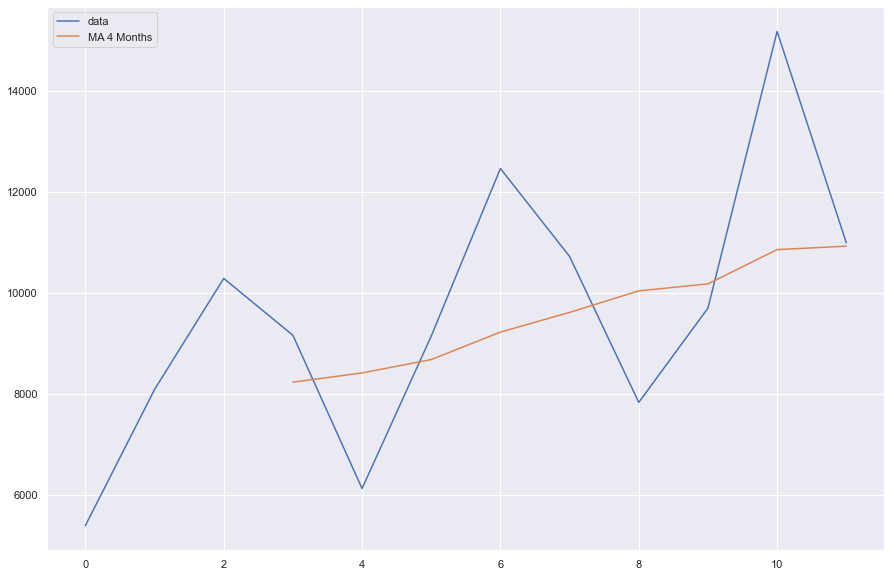

In [7]:
#Moving Average
plt.figure(figsize=[15,10])
plt.grid(True)
plt.plot(data['Sales'],label='data')
plt.plot(data['MA_4'],label='MA 4 Months')
plt.legend(loc=2)

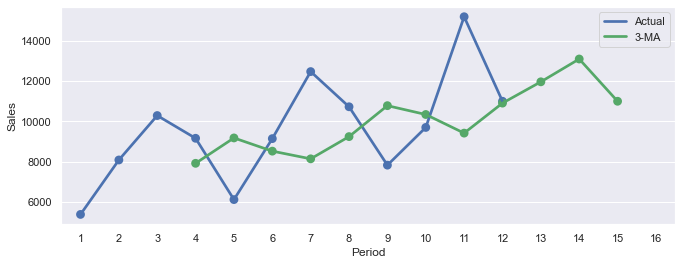

In [8]:
# Using moving average
def moving_average(data, k, to_period):
    moving_average_data = pd.DataFrame(columns=['Period','Sales'])
    num_data = len(data)
    for m in range(0, to_period):
        if m < k:
            sale_predict = float('nan')
        else:
            history = data['Sales'][m-k:m]
            sale_predict = history.mean()
        moving_average_data.loc[m] = [m+1, sale_predict]
    
    moving_average_data['Period'] = moving_average_data['Period'].astype(int)
    return moving_average_data

f, ax = plt.subplots(1, 1)
ma_data = moving_average(data, 3, 16)
sns.pointplot(x='Period', y='Sales', data=data, color='b')
sns.pointplot(x='Period', y='Sales', data=ma_data, color='g')
ax.legend(handles=ax.lines[::len(data)+1], labels=["Actual", "3-MA"])
plt.show()

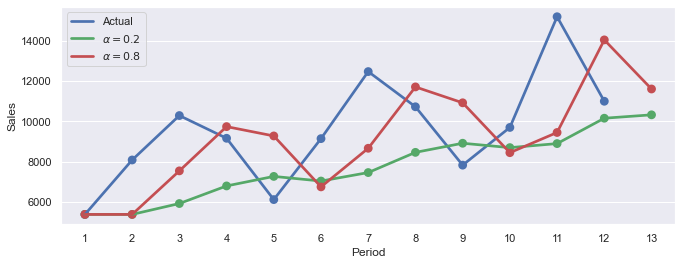

In [9]:
#using Exponentional smoothing 
def exponential_smoothing(data, alpha):
    es_data = pd.DataFrame(columns=['Period','Sales'])
    es_data.loc[0] = [1, data['Sales'][0]]
    num_data = len(data)
    for m in range(0, num_data):
        sale_predict = alpha * data['Sales'][m] + (1-alpha) * es_data['Sales'][m]
        es_data.loc[m+1] = [m+2, sale_predict]
        
    es_data['Period'] = es_data['Period'].astype(int)
    return es_data

f, ax = plt.subplots(1, 1)
es_data_02 = exponential_smoothing(data, 0.2)
es_data_08 = exponential_smoothing(data, 0.8)
sns.pointplot(ax=ax, x='Period', y='Sales', data=data, color='b')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_data_02, color='g')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_data_08, color='r')

ax.legend(handles=ax.lines[::len(data)+2], labels=["Actual", r'$\alpha=0.2$', r"$\alpha=0.8$"])
plt.show()

# Linear Regression

In [10]:
def linear_regression(data):
    linear_data = data.copy()
    linear_data['PeriodSales'] = linear_data['Period'] * linear_data['Sales']
    linear_data['Period_2'] = linear_data['Period'] * linear_data['Period']
    linear_data['Sales_2'] = linear_data['Sales'] * linear_data['Sales']
    linear_sum = linear_data.sum()
    linear_mean = linear_data.mean()
    
    b = (linear_sum['PeriodSales'] - len(data) * linear_mean['Period'] * linear_mean['Sales']) \
        / (linear_sum['Period_2']- len(data) * linear_mean['Period'] * linear_mean['Period'])
    a = linear_mean['Sales'] - b * linear_mean['Period']
#     y = a+b*x
    return a,b

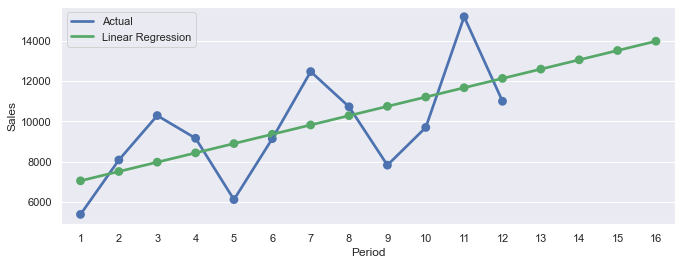

In [11]:
a,b = linear_regression(data)
linear_data = pd.DataFrame(columns=['Period','Sales'])
for m in range(1, 17):
    sale = a + b * m
    linear_data.loc[m-1] = [m,sale]
linear_data['Period'] = linear_data['Period'].astype(int)

f, ax = plt.subplots(1, 1)
sns.pointplot(ax=ax, x='Period', y='Sales', data=data, color='b')
sns.pointplot(ax=ax, x='Period', y='Sales', data=linear_data, color='g')

ax.legend(handles=ax.lines[::len(data)+2], labels=["Actual", "Linear Regression"])
plt.show()

# Predicting the next 4 quarters 

<ipython-input-12-bfc055ec9058>:42: RankWarning: Polyfit may be poorly conditioned
  season_data = predict_with_seasonality(data, [13,14,15,16])


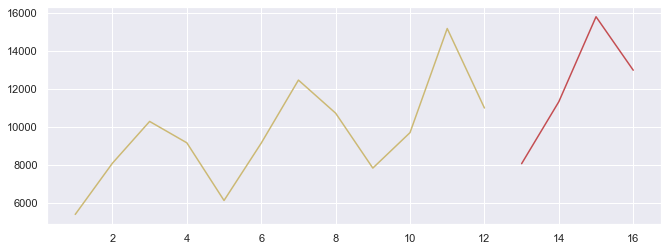

In [12]:
#season function
def get_season(row):
    if row['Period'] >= 5 and row['Period'] <= 8:
        return 'II'
    elif row['Period'] >= 9 and row['Period'] <= 12:
        return 'III'
    else:
        return 'I'
def get_seq(row):
    return row['Period']%4 and row['Period']%4 or 4

def predict_with_seasonality(data, months):
    new_data = data.copy()
    new_data['Season'] = new_data.apply(get_season, axis=1)
    new_data['Seq'] = new_data.apply(get_seq, axis=1)
    
    season_data = pd.DataFrame((new_data.pivot('Seq','Season')['Sales']).to_records())
    season_data.index = season_data['Seq']
    season_data = season_data.drop(['Seq'], axis=1)
    
    avg_data = season_data.apply(np.mean)
    
    seasonal_index_data = pd.DataFrame(columns=['I','II','III'])
    seasonal_index_data['I'] = season_data['I']/avg_data['I']
    seasonal_index_data['II'] = season_data['II']/avg_data['II']
    seasonal_index_data['III'] = season_data['III']/avg_data['III']
    seasonal_index_data['Avg'] = seasonal_index_data.mean(axis=1)
    
    season = np.array([1,2,3])
    avg_arr = np.array([avg_data['I'], avg_data['II'], avg_data['III']])
    fit = np.polyfit(season, avg_arr, 3)
    poly = np.poly1d(fit)
    average_predict = poly(4)
    forecast_data = pd.DataFrame(columns=['Period','Sales'])
    
    forecast_data['Sales'] = seasonal_index_data['Avg']*average_predict
    forecast_data['Period'] = months
#     forecast_df.index = forecast_data['Period']
    forecast_data.index = np.array(months) - 1
    return forecast_data

season_data = predict_with_seasonality(data, [13,14,15,16])

f, ax = plt.subplots(1, 1)
plt.plot(data['Period'], data['Sales'], c='y')
plt.plot(season_data['Period'], season_data['Sales'], c='r')
plt.show()

# EVALUATION

<AxesSubplot:xlabel='Period', ylabel='Sales'>

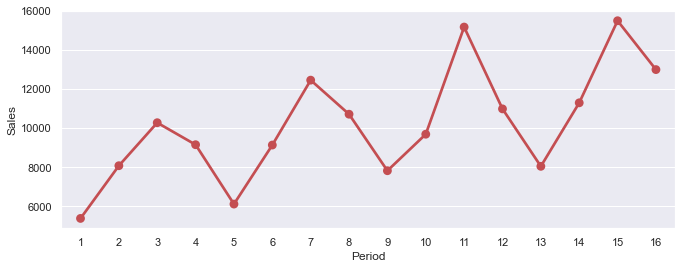

In [13]:
eval_data = pd.read_csv('forecasting_actual.csv')
eval_data = pd.concat([data, eval_data], ignore_index=True)
sns.pointplot(x='Period', y='Sales', data=eval_data, color='r')

In [14]:
MAD = np.absolute(eval_data['Sales'][12:16] - moving_average(eval_data, 3, 16)['Sales'][12:16]).mean()
print("MAD of {0}: {1}".format("3-MA", MAD))
MAD = np.absolute(eval_data['Sales'][12:16] - exponential_smoothing(eval_data, 0.2)['Sales'][12:16]).mean()
print("MAD of {0}: {1}".format("Exponential smoothing with alpha=0.2", MAD))
MAD = np.absolute(eval_data['Sales'][12:16] - exponential_smoothing(eval_data, 0.8)['Sales'][12:16]).mean()
print("MAD of {0}: {1}".format("Exponential smoothing with alpha=0.8", MAD))
MAD = np.absolute(eval_data['Sales'][12:16] - linear_data['Sales'][12:16]).mean()
print("MAD of {0}: {1}".format("Linear Regression", MAD))
MAD = np.absolute(eval_data['Sales'][12:16] - season_data['Sales'][0:4]).mean()
print("MAD of {0}: {1}".format("Seasonality Method", MAD))

MAD of 3-MA: 2694.75
MAD of Exponential smoothing with alpha=0.2: 2707.7580143305513
MAD of Exponential smoothing with alpha=0.8: 3088.7232615120074
MAD of Linear Regression: 2309.1480186480185
MAD of Seasonality Method: 85.88221407247761


In [15]:
MSE = (eval_data['Sales'][12:16] - moving_average(eval_data, 3, 16)['Sales'][12:16])**2
MSE = MSE.mean()
print("MSE of {0}: {1}".format("3-MA", MSE))
MSE = (eval_data['Sales'][12:16] - exponential_smoothing(eval_data, 0.2)['Sales'][12:16])**2
MSE = MSE.mean()
print("MSE of {0}: {1}".format("Exponential smoothing with alpha=0.2", MSE))
MSE = (eval_data['Sales'][12:16] - exponential_smoothing(eval_data, 0.8)['Sales'][12:16])**2
MSE = MSE.mean()
print("MSE of {0}: {1}".format("Exponential smoothing with alpha=0.8", MSE))
MSE = (eval_data['Sales'][12:16] - linear_data['Sales'][12:16])**2
MSE = MSE.mean()
print("MSE of {0}: {1}".format("Linear Regression", MSE))
MSE = (eval_data['Sales'][12:16] - season_data['Sales'][0:4])**2
MSE = MSE.mean()
print("MSE of {0}: {1}".format("Seasonality Method", MSE))

MSE of 3-MA: 11544241.36111111
MSE of Exponential smoothing with alpha=0.2: 9744054.271861337
MSE of Exponential smoothing with alpha=0.8: 10909182.694821384
MSE of Linear Regression: 7123661.909756519
MSE of Seasonality Method: 22206.08964632527


# RECOMMENDATION SYSTEM

In [16]:
###Basics of Recommendation Algorithm
from scipy.spatial.distance import cosine
import sklearn.metrics as metrics
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import correlation, cosine
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.metrics import pairwise_distances
from sklearn.metrics import mean_squared_error


In [17]:
M = np.asarray([[4,3,2,3], 
                [1,2,3,1],
                [np.nan,2,1,np.nan],
                [4,3,np.nan,np.nan],
#                [1,1,1,1],
               ])
print(M.shape)
print(np.nanmean(M, axis=0))
pd.DataFrame(M)

(4, 4)
[3.  2.5 2.  2. ]


,0,1,2,3
0,4.0,3.0,2.0,3.0
1,1.0,2.0,3.0,1.0
2,NaN,2.0,1.0,NaN
3,4.0,3.0,NaN,NaN


In [18]:
#Computing Similarities 
#Cosine
import math
def cosine_similarity(v1,v2, metric='cosine'):
    if metric == 'correlation':
        v1 = v1 - np.nanmean(v1)
        v2 = v2 - np.nanmean(v2)
    "compute similarity of v1 to v2: (v1 dot v2)/{||v1||*||v2||)"
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x = v1[i]; y = v2[i]
        if np.isnan(x) or np.isnan(y): continue
        sumxx += x*x
        sumyy += y*y
        sumxy += x*y
    return sumxy/math.sqrt(sumxx*sumyy)

def sim_matrix(M, dimension='user', metric='cosine'):
    N = M.shape[0] if dimension == 'user' else M.shape[1]
    sim = np.zeros([N,N])
    for i in range(N):
        for j in range(N):
            if i == j:
                sim[i,j] = 0 #Cancel out the effect of self-similarity in the sums later
                continue
            if dimension == 'user':
                v1, v2 = M[i,:], M[j,:]
            else:
                v1, v2 = M[:,i], M[:,j]
            sim[i][j] = cosine_similarity(v1,v2,metric)
    return sim

In [19]:
cosine_similarity(M[0,:], M[2,:], 'cosine')

0.9922778767136677

In [20]:
sim_matrix(M, 'user')

array([[0.        , 0.79582243, 0.99227788, 1.        ],
       [0.79582243, 0.        , 0.86824314, 0.89442719],
       [0.99227788, 0.86824314, 0.        , 1.        ],
       [1.        , 0.89442719, 1.        , 0.        ]])

In [21]:
sim_matrix(M, 'item')

array([[0.        , 0.9649505 , 0.73994007, 0.99705449],
       [0.9649505 , 0.        , 0.90748521, 0.96476382],
       [0.73994007, 0.90748521, 0.        , 0.78935222],
       [0.99705449, 0.96476382, 0.78935222, 0.        ]])

In [22]:
sim_matrix(M, 'item', 'correlation')

array([[ 0.        ,  0.94280904, -0.89442719,  0.9486833 ],
       [ 0.94280904,  0.        ,  0.        ,  1.        ],
       [-0.89442719,  0.        ,  0.        , -0.70710678],
       [ 0.9486833 ,  1.        , -0.70710678,  0.        ]])

In [23]:
#Computing missing rating following collaborative approach 
#Assumption: Using all Neighbours
# Some tests
n_users, n_items = M.shape
avg_ratings = np.nanmean(M, axis=1)
sim_users = sim_matrix(M, 'user', 'cosine')
print(sim_users[2])
print(M[:,0])
print(avg_ratings)
print(M[:,0] - avg_ratings)
print(sim_users[2] * (M[:,0] - avg_ratings))

[0.99227788 0.86824314 0.         1.        ]
[ 4.  1. nan  4.]
[3.   1.75 1.5  3.5 ]
[ 1.   -0.75   nan  0.5 ]
[ 0.99227788 -0.65118236         nan  0.5       ]


In [24]:
def user_cf(M, metric='cosine'):
    pred = np.copy(M)
    n_users, n_items = M.shape
    avg_ratings = np.nanmean(M, axis=1)
    sim_users = sim_matrix(M, 'user', metric)
    for i in range(n_users):
        for j in range(n_items):
            if np.isnan(M[i,j]):
                pred[i,j] = avg_ratings[i] + np.nansum(sim_users[i] * (M[:,j] - avg_ratings)) / sum(sim_users[i])
    return pred

In [25]:
print("User-based CF (Cosine): \n" + str(pd.DataFrame(user_cf(M, 'cosine'))))
print("User-based CF (Pearson): \n" + str(pd.DataFrame(user_cf(M, 'correlation'))))

User-based CF (Cosine): 
          0    1         2         3
0  4.000000  3.0  2.000000  3.000000
1  1.000000  2.0  3.000000  1.000000
2  1.794036  2.0  1.000000  1.272355
3  4.000000  3.0  3.368034  3.268237
User-based CF (Pearson): 
          0    1         2         3
0  4.000000  3.0  2.000000  3.000000
1  1.000000  2.0  3.000000  1.000000
2  0.764822  2.0  1.000000  1.009169
3  4.000000  3.0  4.616077  2.935013


In [26]:
#missing rating using item-based CF
def item_cf(M, metric='cosine'):
    pred = np.copy(M)
    n_users, n_items = M.shape
    avg_ratings = np.nanmean(M, axis=0)
    sim_items = sim_matrix(M, 'item', metric)
    for i in range(n_users):
        for j in range(n_items):
            if np.isnan(M[i,j]):
                pred[i,j] = avg_ratings[j] + np.nansum(sim_items[j] * (M[i,:] - avg_ratings)) / sum(sim_items[j])
    return pred

In [27]:
print("Item-based CF (Cosine): \n" + str(pd.DataFrame(item_cf(M, 'cosine'))))
print("Item-based CF (Pearson): \n" + str(pd.DataFrame(item_cf(M, 'correlation'))))

Item-based CF (Cosine): 
         0    1         2         3
0  4.00000  3.0  2.000000  3.000000
1  1.00000  2.0  3.000000  1.000000
2  2.54758  2.0  1.000000  1.537748
3  4.00000  3.0  2.489861  2.537748
Item-based CF (Pearson): 
          0    1         2        3
0  4.000000  3.0  2.000000  3.00000
1  1.000000  2.0  3.000000  1.00000
2  3.424268  2.0  1.000000  2.16681
3  4.000000  3.0  2.558482  3.16681


# EVALUATING RECOMMENDATION ALGORITHM

In [28]:
#Predictive Accuracy
M_result = np.asarray([[4,3,2,3], 
                [1,2,3,1],
                [1,2,1,2],
                [4,3,2,4]])
pd.DataFrame(M_result)

,0,1,2,3
0,4,3,2,3
1,1,2,3,1
2,1,2,1,2
3,4,3,2,4


In [29]:
def evaluateRS(ratings, groundtruth, method='user_cf', metric='cosine'):
    if method == 'user_cf':
        prediction = user_cf(ratings, metric)
    else:
        prediction = item_cf(ratings, metric)
    MSE = mean_squared_error(prediction, groundtruth)
    RMSE = round(sqrt(MSE),3)
    print("RMSE using {0} approach ({2}) is: {1}".format(method, RMSE, metric))
    print(pd.DataFrame(prediction))
    return

In [30]:
evaluateRS(M, M_result, 'user_cf', 'cosine')
evaluateRS(M, M_result, 'user_cf', 'correlation')
evaluateRS(M, M_result, 'item_cf', 'cosine')
evaluateRS(M, M_result, 'item_cf', 'correlation')

RMSE using user_cf approach (cosine) is: 0.472
          0    1         2         3
0  4.000000  3.0  2.000000  3.000000
1  1.000000  2.0  3.000000  1.000000
2  1.794036  2.0  1.000000  1.272355
3  4.000000  3.0  3.368034  3.268237
RMSE using user_cf approach (correlation) is: 0.751
          0    1         2         3
0  4.000000  3.0  2.000000  3.000000
1  1.000000  2.0  3.000000  1.000000
2  0.764822  2.0  1.000000  1.009169
3  4.000000  3.0  4.616077  2.935013
RMSE using item_cf approach (cosine) is: 0.558
         0    1         2         3
0  4.00000  3.0  2.000000  3.000000
1  1.00000  2.0  3.000000  1.000000
2  2.54758  2.0  1.000000  1.537748
3  4.00000  3.0  2.489861  2.537748
RMSE using item_cf approach (correlation) is: 0.657
          0    1         2        3
0  4.000000  3.0  2.000000  3.00000
1  1.000000  2.0  3.000000  1.00000
2  3.424268  2.0  1.000000  2.16681
3  4.000000  3.0  2.558482  3.16681


# ACCURACY

In [31]:
import scipy.stats as stats

def evaluate_rank(ratings, groundtruth, method='user_cf', metric='cosine'):
    if method == 'user_cf':
        prediction = user_cf(ratings, metric)
    else:
        prediction = item_cf(ratings, metric)
    
    avg_tau = 0
    for i in range(n_users):
        tau, p_value = stats.kendalltau(M_result[i,:], prediction[i,:])
        avg_tau += tau
    avg_tau = avg_tau / n_users
    clear_output(wait=True)
    return avg_tau

results = []
for method in ['user_cf', 'item_cf']:
    for metric in ['cosine', 'correlation']:
        rank_acc = evaluate_rank(M, M_result, method, metric)
        results += ["Rank accuracy of {0} with {1} metric: {2}".format(method[1], metric, rank_acc)]
print("\n".join(results))

Rank accuracy of s with cosine metric: 0.6477056190747297
Rank accuracy of s with correlation metric: 0.56719350585564
Rank accuracy of t with cosine metric: 0.6369306393762916
Rank accuracy of t with correlation metric: 0.7282177322938193


# PRODUCT RECOMMENDATION

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Reading ratings file
ratings = pd.read_csv('ratings(1).csv', encoding='latin-1', usecols=['user_id', 'product_id', 'rating','time_stamp'])
ratings.head()

,user_id,product_id,rating,time_stamp
0,923,0,3,8/12/14
1,924,0,3,16/5/13
2,925,0,4,1/7/13
3,926,0,4,28/7/11
4,927,0,4,1/11/10


In [40]:
# Group dataset by 'user_id', and 'product_id'
count_by_user = ratings.groupby(['user_id', 'product_id']).agg(['count', 'mean'])
count_by_user

rating     
                    count mean
user_id product_id            
923     0               1    3
        19              1    5
        40              1    4
        63              1    4
        79              1    3

In [43]:
# To check if there are users who rate a product multiple time
result_df = count_by_user.loc[count_by_user['rating']['count'] > 1]
result_df

Empty DataFrame
Columns: [(rating, count), (rating, mean)]
Index: []

In [44]:
data = ratings
s = data.user_id.value_counts()
selectedUsers = s[(s>30)&(s<35)].index
print(selectedUsers)

Int64Index([ 3148,  8207, 13523, 20134,  2443,  4441,  7312,  8748, 13471,
            22156,
            ...
             6273,  2753, 18592, 10987,  1049, 31290, 15284,  7354, 20875,
             1948],
           dtype='int64', length=179)


In [45]:
ratings = ratings[ratings.user_id.isin(selectedUsers)]
ratings.shape

(5810, 4)

In [46]:
test_data = ratings.groupby(['user_id']).agg(['count'])
test_data

,product_id,rating,time_stamp
,count,count,count
user_id,,,
931,31,31,31
1049,31,31,31
1059,33,33,33
1118,31,31,31
1246,32,32,32
...,...,...,...
27445,33,33,33
29327,34,34,34


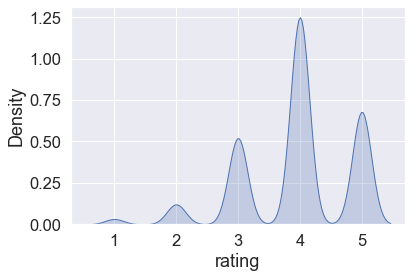

In [47]:
sns.set_style('whitegrid')
sns.set(font_scale=1.5)
%matplotlib inline

# Display distribution of rating
sns.kdeplot(ratings['rating'].fillna(ratings['rating'].median()), shade=True);

# Collaborative Filtering Recommendation Model¶

In [48]:
import math
def correlation_similarity(v1,v2):
    v1 = v1 - np.nanmean(v1)
    v2 = v2 - np.nanmean(v2)
    "compute similarity of v1 to v2: (v1 dot v2)/{||v1||*||v2||)"
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x = v1[i]; y = v2[i]
        if np.isnan(x) or np.isnan(y) or x == 0 or y ==0: continue
        sumxx += x*x
        sumyy += y*y
        sumxy += x*y
    if sumxx == 0 and sumyy == 0:
        sumxx = sumyy = 1
    return sumxy/math.sqrt(sumxx*sumyy)

def sim_matrix(M, dimension='user'):
    N = M.shape[0] if dimension == 'user' else M.shape[1]
    print(N)
    sim = np.zeros([N,N])
    for i in range(N):
        for j in range(N):
            if i == j:
                sim[i,j] = 0 #Cancel out the effect of self-similarity in the sums later
                continue
            if dimension == 'user':
                v1, v2 = M[i,:], M[j,:]
            else:
                v1, v2 = M[:,i], M[:,j]
            sim[i][j] = correlation_similarity(v1,v2)
    print(sim.shape)
    return sim

In [49]:
# Fill NaN values in user_id and product_id column with 0
ratings['user_id'] = ratings['user_id'].fillna(0)
ratings['product_id'] = ratings['product_id'].fillna(0)

# Replace NaN values in rating column with average of all values
ratings['rating'] = ratings['rating'].fillna(ratings['rating'].mean())

<ipython-input-49-79dc2baf34f4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings['user_id'] = ratings['user_id'].fillna(0)
<ipython-input-49-79dc2baf34f4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings['product_id'] = ratings['product_id'].fillna(0)
<ipython-input-49-79dc2baf34f4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [50]:
# select a subset of users and products
ratings = ratings[ratings.groupby('user_id').user_id.transform('count')>10].copy() 
ratings = ratings[ratings.groupby('product_id').product_id.transform('count')>7].copy() 

In [51]:
user_ids = ratings['user_id'].values
product_ids =  ratings['product_id'].values
print(len(user_ids))
print(len(product_ids))

4222
4222


In [52]:
from sklearn.model_selection import train_test_split
#train_data, test_data = train_test_split(ratings, test_size=0.5)
itrain, itest, utrain, utest, train_data, test_data = train_test_split(
     product_ids, user_ids, ratings, train_size=0.5, stratify=product_ids, random_state=0)
print(test_data.shape)
print(train_data.shape)

(2111, 4)
(2111, 4)


In [53]:
# Create two user-item matrices, one for training and another for testing
train_data_matrix = train_data.pivot_table(index='product_id', columns='user_id', values='rating').astype('float64')
test_data_matrix = test_data.pivot_table(index='product_id', columns='user_id', values='rating').astype('float64')
print(test_data_matrix.shape)
print(train_data_matrix.shape)

(248, 179)
(248, 179)


In [55]:
user_correlation = sim_matrix(train_data_matrix.values)
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)
print(user_correlation.shape)

248
(248, 248)
[[ 0. -1.  0. ...  0.  1.  0.]
 [-1.  0.  1. ...  1. -1.  0.]
 [ 0.  1.  0. ...  1.  0.  0.]
 ...
 [ 0.  1.  1. ...  0.  1.  0.]
 [ 1. -1.  0. ...  1.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
(248, 248)


In [56]:
# Item Similarity Matrix
item_correlation = sim_matrix(train_data_matrix.values, 'item')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)
print(item_correlation.shape)

179
(179, 179)
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -1.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.         -0.95611182
   1.        ]
 [ 0.          0.          0.         ... -0.95611182  0.
   0.        ]
 [ 0.         -1.          0.         ...  1.          0.
   0.        ]]
(179, 179)


In [57]:
def user_cf(M, sim_users):
    pred = np.copy(M)
    n_users, n_items = M.shape
    avg_ratings = np.nanmean(M, axis=1)
    for i in range(n_users):
        for j in range(n_items):
            if np.isnan(M[i,j]):
                pred[i,j] = avg_ratings[i] + np.nansum(sim_users[i] * (M[:,j] - avg_ratings)) / sum(sim_users[i])
    return pred
def item_cf(M, sim_items):
    pred = np.copy(M)
    n_users, n_items = M.shape
    avg_ratings = np.nanmean(M, axis=0)
    for i in range(n_users):
        for j in range(n_items):
            if np.isnan(M[i,j]):
                pred[i,j] = avg_ratings[j] + np.nansum(sim_items[j] * (M[i,:] - avg_ratings)) / sum(sim_items[j])
    return pred

In [58]:
# Function to predict ratings
def predict(ratings, similarity, type='user'):
    if type == 'user':
        pred = user_cf(ratings, user_correlation)
    elif type == 'item':
        pred = item_cf(ratings, item_correlation)
    return pred

In [59]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Function to calculate RMSE
def rmse(pred, actual):
    return sqrt(np.nanmean(pred - actual)** 2)

In [60]:
# Predict ratings on the training data with both similarity score
user_prediction = predict(train_data_matrix.values, user_correlation, type='user')
item_prediction = predict(train_data_matrix.values, item_correlation, type='item')

# RMSE on the test data
print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix.values)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix.values)))

<ipython-input-57-43565cba0434>:8: RuntimeWarning: invalid value encountered in double_scalars
  pred[i,j] = avg_ratings[i] + np.nansum(sim_users[i] * (M[:,j] - avg_ratings)) / sum(sim_users[i])
<ipython-input-57-43565cba0434>:17: RuntimeWarning: invalid value encountered in double_scalars
  pred[i,j] = avg_ratings[j] + np.nansum(sim_items[j] * (M[i,:] - avg_ratings)) / sum(sim_items[j])


User-based CF RMSE: 0.025164893797670552
Item-based CF RMSE: 0.09083895661565908
